Возьмите два небольших корпуса (можно взять "Анну Каренину" и сонеты Шекспира). Напишите программу, которая наглядно демонстрирует ответ на вопрос: можно ли различить предложения этих двух текстов, пользуясь лишь следующими признаками:
- длина предложения в буквах,
- число различных букв в предложении,
- число гласных в предложении,
- медиана числа букв в слове,
- медиана числа гласных в слове.

Для этого превратите каждое предолжение в список соответствующих чисел. Выведите на экран распределение данных по предложениям по двум осям, дающим наилучшее разделение (пара осей для обоих текстов должна быть одинаковой).


Взять признаки из предыдущего задания и построить классификатор, который пытался бы угадать, к какому корпусу относится предложение с определенным набором признаков. Привести 3 примера, где классификатор ошибается.

In [2]:
import re
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [74]:
# Split into sentences
with open('anna.txt') as f:
    anna = f.read()
with open('sonets.txt') as f:
    sonets = f.read()

anna_sentences = re.split(r'(?:[.]\s*){3}|[.?!]', anna)
sonet_sentences = re.split(r'(?:[.]\s*){3}|[.?!]', sonets)

print(len(anna_sentences))
print(len(sonet_sentences))
# я почищу пустые строки, потому что зачем
anna_sentences = [sent for sent in anna_sentences if sent.strip() != '']
sonet_sentences = [sent for sent in sonet_sentences if sent.strip() != '']

21499
1378


In [78]:
# Get the data
def len_wds(sent):
    return[len(wd.strip()) for wd in sent.split()]


def num_vows(sent):
    vows = re.compile('[аэоуыяеёюи]')
    return [len(re.findall(vows, wd)) for wd in sent.split()]


def get_data(sents):
    praed = [(len_wds(sentence), num_vows(sentence), len(set(sentence.lower()))) for sentence in sents]
    data = [(sum(sent[0]), sent[2], sum(sent[1]), np.median(sent[0]), np.median(sent[1])) for sent in praed]
    return data

anna_data, sonets_data = get_data(anna_sentences), get_data(sonet_sentences)

Дата готова, можно начинать PCA

In [89]:
from matplotlib import mlab
data = np.vstack((anna_data, sonets_data))
p = mlab.PCA(data, True)
N = len(anna_data)

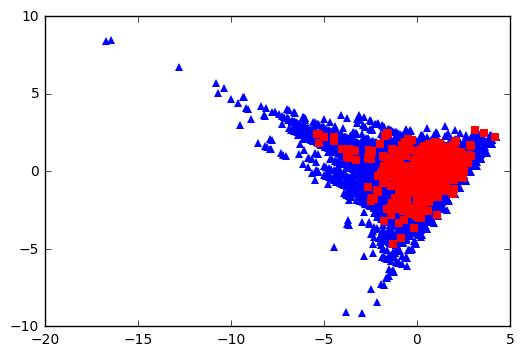

In [103]:
plt.plot(p.Y[:N,0], p.Y[:N,1], '^b', p.Y[N:,0], p.Y[N:,1], 'sr', markeredgewidth=0.0)

PCA готово (?), теперь классифакатор

In [114]:
from sklearn import grid_search, svm
from pymystem3 import Mystem
m = Mystem()

def mystem(sentence):
    sentence = sentence.strip()
    ananas = m.analyze(sentence)
    return ananas

def nouns(analysis):
    try:
        return len([w for w in analysis if 'S,' in w['analysis'][0]['gr']])
    except:
        return 0

def adjectives(analysis):
    try:
        return len([w for w in analysis if 'A=' in w['analysis'][0]['gr']])
    except:
        return 0

def verbs(analysis):
    try:
        return len([w for w in analysis if 'V,' in w['analysis'][0]['gr']])
    except:
        return 0

def adverbs(analysis):
    try:
        return len([w for w in analysis if 'ADV=' in w['analysis'][0]['gr']])
    except:
        return 0

def pronouns(analysis):
    try:
        return len([w for w in analysis if 'PRO' in w['analysis'][0]['gr']])
    except:
        return 0

def prepositions(analysis):
    try:
        return len([w for w in analysis if 'PR=' in w['analysis'][0]['gr']])
    except:
        return 0

# нам же всё равно не нужны пустые строки (да кому они вообще нужны)

corp1_sentences = sonet_sentences
corp2_sentences = anna_sentences
corp1_data = []
corp2_data = []

print('Processing corp1...')
for sent in corp1_sentences:
    ana = mystem(sent)
    ana = [analysis for analysis in ana if 'analysis' in analysis.keys() and analysis['analysis'] != []]
    corp1_data.append([1, adjectives(ana), nouns(ana), verbs(ana), adverbs(ana), pronouns(ana), prepositions(ana)])
print('Processing corp2...')
for sent in corp2_sentences:
    ana = mystem(sent)
    ana = [analysis for analysis in ana if 'analysis' in analysis.keys() and analysis['analysis'] != []]
    corp2_data.append([2, adjectives(ana), nouns(ana), verbs(ana), adverbs(ana), pronouns(ana), prepositions(ana)])

corp1_data = np.array(corp1_data)
corp2_data = np.array(corp2_data)
data = np.vstack((corp1_data, corp2_data))

import warnings
warnings.filterwarnings('ignore')
print('Classifying...')
parameters = {'C': (.1, .5, 1.0, 1.5, 1.7, 2.0)}
gs = grid_search.GridSearchCV(svm.LinearSVC(), parameters)
gs.fit(data[:, 1:], data[:, 0])
print('Best result is ',gs.best_score_)
clf = svm.LinearSVC(C=gs.best_estimator_.C)
clf.fit(data[::2, 1:], data[::2, 0])
wrong = 0
for obj in data[1::2, :]:
    label = clf.predict(obj[1:])
    if label != obj[0] and wrong < 3:
        print('Пример ошибки машины: class = ', obj[0], ', label = ', label, ', экземпляр ', obj[1:])
        wrong += 1
    elif wrong > 3:
        break

Processing corp1...
Processing corp2...
Classifying...
Best result is  0.939760102687
Пример ошибки машины: class =  1 , label =  [2] , экземпляр  [1 4 3 0 1 0]
Пример ошибки машины: class =  1 , label =  [2] , экземпляр  [1 8 2 0 1 2]
Пример ошибки машины: class =  1 , label =  [2] , экземпляр  [3 5 4 0 3 0]


Вроде всё?